In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
pip uninstall -y yfinance

Found existing installation: yfinance 0.2.52
Uninstalling yfinance-0.2.52:
  Successfully uninstalled yfinance-0.2.52


In [ ]:
pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.3 MB/s eta 0:00:00


In [3]:
# Load S&P 500 companies as a proxy for Fortune 500
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

In [4]:
print(sp500_tickers[:5])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


In [5]:
tech_tickers = [ticker for ticker in sp500_tickers if yf.Ticker(ticker).info.get('sector') == "Technology"]

In [6]:
print(len(tech_tickers))

82


In [7]:
print(tech_tickers[:10])

['ACN', 'ADBE', 'AMD', 'AKAM', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET']


In [8]:
stock = yf.Ticker('AAPL')
df = stock.history(period="6mo")
df.index = df.index.tz_localize(None)
print(df.index)

DatetimeIndex(['2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15',
               '2024-08-16', '2024-08-19', '2024-08-20', '2024-08-21',
               '2024-08-22', '2024-08-23',
               ...
               '2025-01-28', '2025-01-29', '2025-01-30', '2025-01-31',
               '2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06',
               '2025-02-07', '2025-02-10'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)


In [18]:
import pandas as pd
import yfinance as yf

def get_stock_score(ticker, date):
    date = pd.to_datetime(date)
    stock = yf.Ticker(ticker)
    df = stock.history(period="24mo")

    # Remove timezone info
    df.index = df.index.tz_localize(None)
    date = date.tz_localize(None)

    if date > df.index.max():
        print("Requested date is in the future. No data available.")
        return 0  # Return 0 for future dates

    if date not in df.index:
        return 0  # Return 0 if no data exists for this date

    df_trimmed = df.loc[(df.index <= date) & (df.index > date - pd.Timedelta(days=350))]

    if len(df_trimmed) < 200:
        print(f"Not enough data for {ticker} (200-day MA), skipping.")
        return -1

    # Moving Averages
    ma_50 = df_trimmed["Close"].rolling(50).mean().iloc[-1]
    ma_200 = df_trimmed["Close"].rolling(200).mean().iloc[-1]
    close_price = df_trimmed["Close"].iloc[-1]

    if pd.isna(ma_50) or pd.isna(ma_200):
        print(f"NaN in moving averages for {ticker}, skipping.")
        return 0

    # RSI Calculation (14 periods)
    delta = df_trimmed["Close"].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean().iloc[-1]
    loss = -delta.where(delta < 0, 0).rolling(14).mean().iloc[-1]

    if pd.isna(gain) or pd.isna(loss):
        print(f"NaN in RSI components for {ticker}, skipping.")
        return 0

    if loss == 0:
        rsi = 100
    else:
        rsi = 100 - (100 / (1 + (gain / loss)))

    # Bollinger Bands (20-day period, 2 standard deviations)
    rolling_mean = df_trimmed["Close"].rolling(20).mean().iloc[-1]
    rolling_std = df_trimmed["Close"].rolling(20).std().iloc[-1]
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)

    if pd.isna(rolling_mean) or pd.isna(rolling_std):
        print(f"NaN in Bollinger Bands for {ticker}, skipping.")
        return 0

    # Momentum Score
    ma50_diff = (close_price - ma_50) / ma_50
    ma200_diff = (close_price - ma_200) / ma_200

    if close_price > ma_50 > ma_200:
        momentum = (ma50_diff + ma200_diff) * 0.5
    elif close_price < ma_50 < ma_200:
        momentum = (ma50_diff + ma200_diff) * 0.5
    else:
        momentum = (ma50_diff + ma200_diff) * 0.25

    momentum = min(max(momentum, 0), 1)  # Ensure between 0 and 1

    # RSI Contribution (normalized between 0 and 1)
    rsi_contribution = max(0, min(1, (60 - rsi) / 60))

    # Bollinger Band Contribution
    if close_price < lower_band:
        bollinger_score = 1  # Strong buy signal
    elif close_price > upper_band:
        bollinger_score = 0  # Strong sell signal
    else:
        bollinger_score = 1 - (close_price - lower_band) / (upper_band - lower_band)

    bollinger_score = max(0, min(bollinger_score, 1))

    # Final Score Calculation (without mean reversion)
    score = (momentum * 0.4) + (rsi_contribution * 0.3) + (bollinger_score * 0.3)
    score = max(0, min(score, 1))  # Ensure score is always between 0 and 1

    print(f"Momentum: {momentum}, RSI: {rsi_contribution}, Bollinger: {bollinger_score}")
    print(f"Final Score for {ticker} on {date.date()}: {score}")

    return score


In [19]:
print(get_stock_score("AAPL", "2024-08-20"))

Momentum: 0.10846665897153608, RSI: 0.06298388037541044, Bollinger: 0.13404902403255248
Final Score for AAPL on 2024-08-20: 0.1024965349110033
0.1024965349110033


In [14]:
pip install pandas-market-calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.0/198.0 kB 10.2 MB/s eta 0:00:00


In [20]:
import pandas_market_calendars as mcal

def is_market_open(current_date):
    market_calendar = mcal.get_calendar('NYSE')

    # Convert current_date to datetime object if it is not already
    if isinstance(current_date, str):
        current_date = datetime.strptime(current_date, "%Y-%m-%d")

    # Get the market open days for the given date (only one day)
    market_schedule = market_calendar.valid_days(start_date=current_date, end_date=current_date)

    # Check if current_date is in the valid market days (convert to date to match comparison)
    return current_date.date() in market_schedule.date


In [21]:
import heapq

def backtest(start_date, end_date, tickers, initial_capital=100000):
    """Backtest the strategy for a given period"""
    cash = initial_capital
    portfolio_value = []

    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Min-heap for tracking the top 10 stocks
    portfolio_heap = []
    portfolio_tickers = set()

    max_amount_to_invest = 20000

    while current_date <= end_date:
        # print(f"🔎 Backtesting on {current_date}")

        if not is_market_open(current_date):
          # Implement your logic for a market open day (buy/sell, update portfolio)
          print(f"Market is not open on {current_date.date()}")
          current_date += pd.Timedelta(days=1)

          if is_market_open(current_date):
            new_portfolio_heap = []
            for score, ticker, shares, bought_price in portfolio_heap:
                # Recalculate the score for each stock in the portfolio
                new_score = get_stock_score(ticker, current_date)
                heapq.heappush(new_portfolio_heap, (new_score, ticker, shares, bought_price))

            portfolio_heap = new_portfolio_heap
          continue

        # Calculate score for each stock
        scores = []
        for ticker in tickers:
            score = get_stock_score(ticker, current_date)
            scores.append((score, ticker))

        # Sort by score in descending order
        scores.sort(reverse=True, key=lambda x: x[0])

        # Iterate through the sorted scores and maintain a min-heap of the top 10 stocks
        for score, ticker in scores:
            if score < 0:
              break

            if ticker in portfolio_tickers:
              continue

            stock_data = yf.Ticker(ticker).history(start=current_date, end=current_date + pd.Timedelta(days=1))
            if stock_data.empty:
              continue

            price = stock_data["Close"].iloc[0]

            # If portfolio has fewer than 10 stocks, add the current stock
            if cash >= 15000:
                shares = min(max_amount_to_invest, cash) // price
                print(f"Bought {shares} {ticker} @ {price} on {current_date}")
                heapq.heappush(portfolio_heap, (score, ticker, shares, price))
                portfolio_tickers.add(ticker)
                cash -= shares * price
            else:
                # If the current stock has a better score than the lowest score in the portfolio
                # Replace the stock with the lowest score in the heap
                if score > portfolio_heap[0][0]:
                    # Sell the lowest scoring stock in the portfolio
                    _, worst_ticker, worst_shares, worst_bought_price = heapq.heappop(portfolio_heap)
                    portfolio_tickers.remove(worst_ticker)

                    sold_stock_data = yf.Ticker(worst_ticker).history(start=current_date, end=current_date + pd.Timedelta(days=1))
                    if sold_stock_data.empty:
                      print("ERROR OCCURRED")

                    sold_stock_price = sold_stock_data["Close"].iloc[0]
                    cash += worst_shares * sold_stock_price

                    print(f"Sold {worst_shares} {worst_ticker} @ {sold_stock_price} on {current_date}")

                    # Add the new stock
                    shares = min(max_amount_to_invest, cash) // price
                    heapq.heappush(portfolio_heap, (score, ticker, shares, price))
                    portfolio_tickers.add(ticker)
                    print(f"Bought {shares} {ticker} @ {price} on {current_date}")
                    cash -= shares * price  # Subtract the cash used for the new purchase
                else:
                    break

        # Recalculate portfolio value at the end of each day
        portfolio_value_at_date = cash
        for score, ticker, shares, _ in portfolio_heap:
            curr_ticker_info = yf.Ticker(ticker).history(start=current_date, end=current_date + pd.Timedelta(days=1))
            if curr_ticker_info.empty:
              print("Error when getting curr ticker info")

            price = curr_ticker_info["Close"].iloc[0]

            portfolio_value_at_date += shares * price

        portfolio_value.append((current_date, portfolio_value_at_date))
        current_date += pd.Timedelta(days=1)  # Move to next day

        new_portfolio_heap = []
        for score, ticker, shares, bought_price in portfolio_heap:
            # Recalculate the score for each stock in the portfolio
            new_score = get_stock_score(ticker, current_date)
            heapq.heappush(new_portfolio_heap, (new_score, ticker, shares, bought_price))

        portfolio_heap = new_portfolio_heap


    return portfolio_value

Momentum: 0.11082507600879507, RSI: 0.001690054485096108, Bollinger: 0.1281946080031361
Final Score for AAPL on 2024-08-16: 0.0832954291499877
Momentum: 0, RSI: 0.26572354505055207, Bollinger: 0.4537059950752952
Final Score for MSFT on 2024-08-16: 0.2158288620377542
Momentum: 0, RSI: 0.3471142706824207, Bollinger: 0.6338588141318713
Final Score for GOOG on 2024-08-16: 0.2942919254442876
Momentum: 0, RSI: 0.2682685788453019, Bollinger: 0.4363038007977179
Final Score for AMZN on 2024-08-16: 0.21137171389290593
Momentum: 0.2595936599295426, RSI: 0.01831788272961982, Bollinger: 0.09885714726909034
Final Score for NVDA on 2024-08-16: 0.1389899729714301
Momentum: 0.03769115173358899, RSI: 0.29344384430032083, Bollinger: 0.47706505053014625
Final Score for TSLA on 2024-08-16: 0.24622912914257572
Momentum: 0.1223638957925954, RSI: 0, Bollinger: 0.1706390670123038
Final Score for META on 2024-08-16: 0.10013727842072931
Momentum: 0.15975319282544723, RSI: 0, Bollinger: 0.12886028208431766
Final 

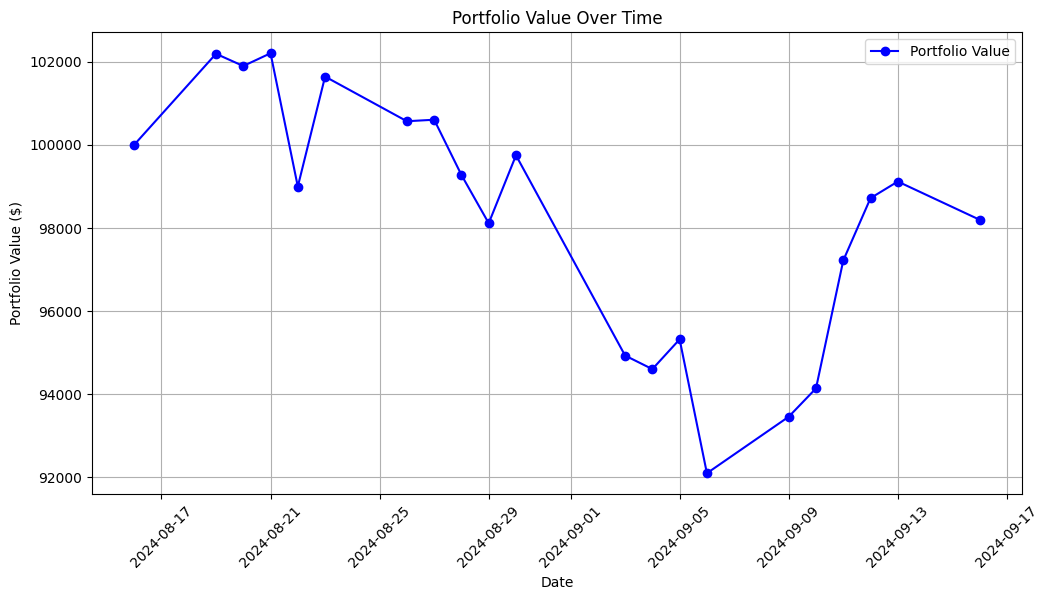

In [22]:
import matplotlib.pyplot as plt

def plot_portfolio_value(portfolio_value):
    # Extract dates and values
    dates = [x[0] for x in portfolio_value]
    values = [x[1] for x in portfolio_value]

    # Plot the graph
    plt.figure(figsize=(12, 6))
    plt.plot(dates, values, marker='o', linestyle='-', color='b', label='Portfolio Value')

    # Format the graph
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better readability

    # Show the plot
    plt.show()

# Call the function with your backtest results
portfolio_value = backtest("2024-08-16", "2024-09-16", ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META', 'TSM', 'V'])
plot_portfolio_value(portfolio_value)